### <font color="#0000dd"> **1.要求动手从0实现logistic回归（只借助Tensor和Numpy相关的库）在人工构造的数据集上进行训练和测试，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析。**</font><br />

In [34]:
import torch
import numpy as np
import random

#### 生成数据

In [38]:
num_inputs = 2
n_data = torch.ones(100,2) #数据的基本形态

# 训练集
x1 = torch.normal(2*n_data,1)
y1 = torch.zeros(100)
x2 = torch.normal(-2*n_data,1)
y2 = torch.ones(100)

x_train = torch.cat((x1,x2),0).type(torch.FloatTensor)
y_train = torch.cat((y1,y2),0).type(torch.FloatTensor)
y_train = y_train.view(-1,1)

# 测试集
x1 = torch.normal(2*n_data,1)
y1 = torch.zeros(20)
x2 = torch.normal(-2*n_data,1)
y2 = torch.ones(20)

x_test = torch.cat((x1,x2),0).type(torch.FloatTensor)
y_test = torch.cat((y1,y2),0).type(torch.FloatTensor)
y_test = y_test.view(-1,1)

#### 读取数据

In [44]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #样本的读取顺序是随机的
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])# 最后一次可能不足一个batch
        yield features.index_select(0,j),labels.index_select(0,j)

#### 构建模型

* 初始化模型参数   

In [69]:
# 将权重初始化成均值为0、标准差为0.01的正态随机数，偏置初始化为0.
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

In [70]:
# 设置梯度传递
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

* 定义模型 

In [28]:
def sigmoid(input_x):
    return 1/(1+torch.exp(-input_x))

def logistic_reg(X,w,b):
    return sigmoid(torch.mm(X,w)+b)

#### 定义损失函数和优化算法

* 二元交叉熵损失函数

In [29]:
def BCE_loss(y_pre,y_truth):
    return y_truth*(-torch.log(y_pre))+(1-y_truth)*(-torch.log(1-y_pre))

* 优化方法
随机梯度下降(SGD)

In [30]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size

#### 模型评估

In [46]:
# 对样本进行预测
def predict(X,w,b,net):
    m = X.shape[0]
    Y_prediction = torch.zeros((m,1))

    A = net(X,w,b)
    for  i in range(m):
        if A[i,0]>0.5:
            Y_prediction[i,0] = 1
        else:
            Y_prediction[i,0] = 0

    return Y_prediction

In [65]:
# 定义准确率
def acc(y_pre,y_truth):
    return 1 - (torch.abs(y_pre - y_truth)).sum()/y_pre.shape[0]

#### 模型训练

In [71]:
lr = 0.03
num_epochs = 10
net = logistic_reg
loss = BCE_loss
batch_size = 100
train_loss = []
train_acc = []
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,x_train,y_train):
        y_pre = predict(X,w,b,net) 
        l = loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_() 
    train_l = loss(net(x_train,w,b),y_train)
    y_pre = predict(x_train,w,b,net)
    accuracy = acc(y_pre,y_train)
    train_loss.append(train_l.mean().item())
    train_acc.append(accuracy)
    print('epoch %d,loss %f,acc %f'%(epoch+1,train_l.mean().item(),accuracy))

epoch 1,loss 0.363748,acc 1.000000
epoch 2,loss 0.245102,acc 1.000000
epoch 3,loss 0.188412,acc 1.000000
epoch 4,loss 0.155413,acc 1.000000
epoch 5,loss 0.133784,acc 1.000000
epoch 6,loss 0.118467,acc 1.000000
epoch 7,loss 0.107002,acc 1.000000
epoch 8,loss 0.098089,acc 1.000000
epoch 9,loss 0.090931,acc 1.000000
epoch 10,loss 0.085046,acc 1.000000


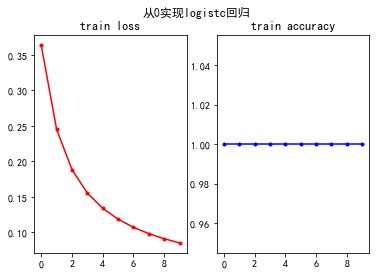

In [72]:
import matplotlib.pyplot as plt
from pylab import mpl
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

plt.subplot(1,2,1)
plt.plot(range(10),train_loss,'r.-')
plt.title('train loss')
plt.subplot(1,2,2)
plt.plot(range(10),train_acc,'b.-')
plt.title('train accuracy')
plt.suptitle('从0实现logistc回归')
plt.savefig('log_0_loss_acc.jpg')

#### 模型测试

In [13]:
test_l = loss(net(x_test,w,b),y_test)
y_pre = predict(x_test,w,b,net)
accuracy = acc(y_pre,y_test)
    
print('loss %f,acc %f'%(test_l.mean().item(),accuracy))

loss 0.068510,acc 1.000000


### <font color="#0000dd"> **2.利用torch.nn实现logistic回归在人工构建的数据集上进行训练和测试，并对结果进行分析，并从loss、训练集以及测试集上的准确率等多个角度对结果进行分析**</font><br />

In [77]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.nn import init
import torch.optim as optim

**读取数据**

In [78]:
batch_size = 20
lr = 0.03
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(x_train,y_train)

# 把dataset放入DataLoader
data_iter = Data.DataLoader(
            dataset = dataset,
            batch_size = batch_size,
            shuffle = True)

**构建模型**

* 定义模型

In [79]:
class LogisticReg(nn.Module):
    def __init__(self,n_feature):
        super(LogisticReg,self).__init__()
        self.lr=nn.Linear(n_feature,1)  
        self.sm=nn.Sigmoid()   

    def forward(self, x):
        x=self.lr(x)
        x=self.sm(x)
        return x

* 模型参数初始化

In [80]:
n_feature = 2
net=LogisticReg(n_feature)

init.normal_(net.lr.weight,mean=0,std=0.01)
init.constant_(net.lr.bias,val=0) 

Parameter containing:
tensor([0.], requires_grad=True)

**定义损失函数和优化器**

In [81]:
loss = nn.BCELoss()

In [82]:
optimizer = optim.SGD(net.parameters(),lr=0.03)

**模型评估**

In [83]:
def predict_nn(X,net):
    m = X.shape[0]
    Y_prediction = torch.zeros((m,1))

    A = net(X)
    for  i in range(m):
        if A[i,0]>0.5:
            Y_prediction[i,0] = 1
        else:
            Y_prediction[i,0] = 0

    return Y_prediction

**模型训练**

In [84]:
num_epochs = 10
train_loss=[]
train_acc=[]
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    y_pre = predict_nn(x_train,net)
    accuracy = acc(y_pre,y_train)
    train_loss.append(l.item())
    train_acc.append(accuracy)
    print('epoch %d,loss: %f，acc: %f'%(epoch,l.item(),accuracy))

epoch 1,loss: 0.369617，acc: 1.000000
epoch 2,loss: 0.230318，acc: 1.000000
epoch 3,loss: 0.167326，acc: 1.000000
epoch 4,loss: 0.184061，acc: 1.000000
epoch 5,loss: 0.144097，acc: 1.000000
epoch 6,loss: 0.123772，acc: 1.000000
epoch 7,loss: 0.100006，acc: 1.000000
epoch 8,loss: 0.112854，acc: 1.000000
epoch 9,loss: 0.076705，acc: 1.000000
epoch 10,loss: 0.120481，acc: 1.000000


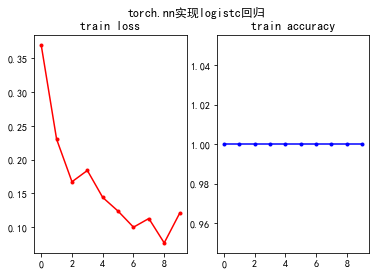

In [85]:
plt.subplot(1,2,1)
plt.plot(range(10),train_loss,'r.-')
plt.title('train loss')
plt.subplot(1,2,2)
plt.plot(range(10),train_acc,'b.-')
plt.title('train accuracy')
plt.suptitle('torch.nn实现logistc回归')
plt.savefig('log_loss_acc.jpg')

**模型测试**

In [86]:
l = loss(net(x_test),y_test.view(-1,1))
y_pre = predict_nn(x_test,net)
accuracy = acc(y_pre,y_test)
print(l,accuracy)

tensor(0.0621, grad_fn=<BinaryCrossEntropyBackward>) tensor(1.)
